In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle

In [2]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [4]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield["date"] = market_yield["date"].shift(-5)
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy["date"] = spy["date"].shift(-5)
spy = processor.column_date_processing(spy)
fred.disconnect()

In [24]:
factors = ["spy"]

In [80]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price["historical_return"] = price["adjclose"].pct_change(65)
        for factor in factors:
            price["factor_return"] = price[factor].pct_change(65)
            price["cov"] = price["factor_return"].rolling(100).cov(price["historical_return"])
            price["var"] = price["factor_return"].rolling(100).var()
            price["beta"] = price["cov"] / price["var"]
            price[f"{factor}_prediction"] = price["beta"] * (price["factor_return"] - price["rf"])
        price["prediction"] = [mean([row[1][f"{factor}_prediction"] for factor in factors]) for row in price.iterrows()]
        price["prediction"] = price["rf"] + price["prediction"]
        price["sigma"] = price["adjclose"].pct_change(65)
        price["excess_return"] = price["prediction"] 
        prices.append(price.dropna())
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:18<00:00, 26.78it/s]


In [81]:
sim = pd.concat(prices)
sim = sim[sim["date"]>datetime(2024,1,1)].dropna()
sim = sim[["date","ticker","adjclose","GICS Sector","excess_return","rf","sigma"]]

In [82]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "bonds": [{} for _ in range(number_of_stocks)],
            "options": [{} for _ in range(number_of_stocks)]
        }
        for _ in sp500["GICS Sector"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000

for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                bonds = copy.deepcopy(position["bonds"])
                options = copy.deepcopy(position["options"])
                
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    option = options[j]
                    bond = bonds[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                        option = Option.update(row, option)
                        position["options"][j] = option
                        bond = Bond.update(row, bond)
                        position["bonds"][j] = bond
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(11):
                position = positions[i]
                sector = list(sp500["GICS Sector"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                bonds = copy.deepcopy(position["bonds"])
                options = copy.deepcopy(position["options"])
                
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    option = options[j]
                    bond = bonds[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        expected_return = stock["excess_return"]
                        notional = stock["pv"] + option["pv"] + bond["pv"]
                        opportunity_row = today[today["GICS Sector"] == sector].sort_values("excess_return", ascending=False).iloc[j]
                        opportunity_cost = opportunity_row["excess_return"]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (opportunity_ticker != ticker):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            option = Option.sell(row, option)
                            position["options"][j] = option
                            bond = Bond.sell(row, bond)
                            position["bonds"][j] = bond
                            stock = Stock.buy(opportunity_row, stock, notional * 1)
                            position["stocks"][j] = stock
                            option = Option.buy(opportunity_row, option, notional * 0)
                            position["options"][j] = option
                            bond = Bond.buy(opportunity_row, bond, notional * 0)
                            position["bonds"][j] = bond
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sector"].unique())[i]
                    bonds = copy.deepcopy(position["bonds"])
                    options = copy.deepcopy(position["options"])
                    stocks = copy.deepcopy(position["stocks"])
                    
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        option = options[j]
                        bond = bonds[j]
                        row = today[today["GICS Sector"] == sector].sort_values("excess_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional * 1)
                        position["stocks"][j] = stock
                        option = Option.buy(row, option, notional * 0)
                        position["options"][j] = option
                        bond = Bond.buy(row, bond, notional * 0)
                        position["bonds"][j] = bond
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

In [83]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [84]:
industry_visualization = pd.DataFrame(portfolios).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left").dropna().merge(market_yield[["date","rf"]],on="date",how="left")
industry_visualization = industry_visualization.groupby(["date","GICS Sector"]).agg({"pv":"sum","rf":"mean"}).reset_index()

In [85]:
industry_visualization

,date,GICS Sector,pv,rf
0,2024-01-02,Communication Services,9090.909091,0.0390
1,2024-01-02,Consumer Discretionary,9090.909091,0.0390
2,2024-01-02,Consumer Staples,9090.909091,0.0390
3,2024-01-02,Energy,9090.909091,0.0390
4,2024-01-02,Financials,9090.909091,0.0390
...,...,...,...,...
1447,2024-07-11,Industrials,8788.419410,0.0436
1448,2024-07-11,Information Technology,21192.980626,0.0436
1449,2024-07-11,Materials,10082.540371,0.0436
1450,2024-07-11,Real Estate,7896.820949,0.0436


In [86]:
# # Number of sectors
# num_sectors = len(industry_visualization["GICS Sector"].unique())

# # Determine the number of rows and columns for the grid
# num_cols = 2
# num_rows = math.ceil(num_sectors / num_cols)

# # Create a figure with subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
# fig.tight_layout(pad=5.0)

# # Flatten the axs array for easy iteration
# axs = axs.flatten()

# # Loop through each unique sector
# for i, sector in enumerate(industry_visualization["GICS Sector"].unique()):
#     # Filter the data for the current sector and sort by date
#     sector_viz = industry_visualization[industry_visualization["GICS Sector"] == sector].sort_values("date")
    
#     # Select the current axis
#     ax1 = axs[i]
    
#     # Plot the 'pv' data on the primary y-axis
#     ax1.plot(sector_viz["date"], sector_viz["pv"], color='b', label='pv')
#     ax1.set_xlabel('Date')
#     ax1.set_ylabel('pv', color='b')
    
#     # Create a secondary y-axis
#     ax2 = ax1.twinx()
    
#     # Plot the 'rf' data on the secondary y-axis
#     ax2.plot(sector_viz["date"], sector_viz["rf"], color='r', label='rf')
#     ax2.set_ylabel('rf', color='r')
    
#     # Set the title
#     ax1.set_title(sector)

# # Remove any unused subplots
# for j in range(i + 1, len(axs)):
#     fig.delaxes(axs[j])

# # Show the plot
# plt.show()

In [87]:
for state in states:
    try:
        state["stock_pv"] = sum([sum([state["positions"][i]["stocks"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["option_pv"] = sum([sum([state["positions"][i]["options"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["bond_pv"] = sum([sum([state["positions"][i]["bonds"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["pv"] = state["cash"] + state["stock_pv"] + state["option_pv"] + state["bond_pv"]
    except Exception as e:
        print(str(e))
        continue

In [88]:
performance = pd.DataFrame(states).dropna()
performance["stock_return"] = (performance["stock_pv"] - performance["stock_pv"].iloc[0]) / performance["stock_pv"].iloc[0]
performance["bond_return"] = (performance["bond_pv"] - performance["bond_pv"].iloc[0]) / performance["bond_pv"].iloc[0]
performance["option_return"] = (performance["option_pv"] - performance["option_pv"].iloc[0]) / performance["option_pv"].iloc[0]
performance["return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

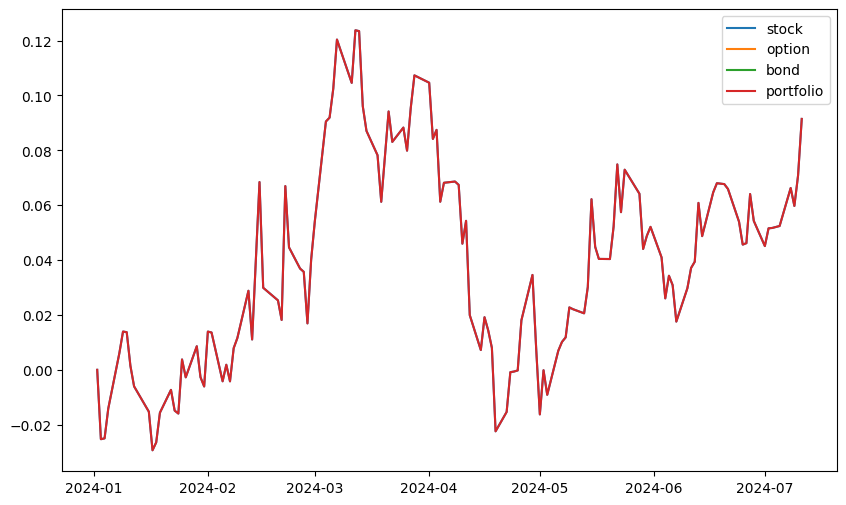

In [89]:
plt.figure(figsize=(10, 6))  
plt.plot(performance["date"].values,performance["stock_return"].values)
plt.plot(performance["date"].values,performance["option_return"].values)
plt.plot(performance["date"].values,performance["bond_return"].values)
plt.plot(performance["date"].values,performance["return"].values)
plt.legend(["stock","option","bond","portfolio"])

In [90]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [91]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

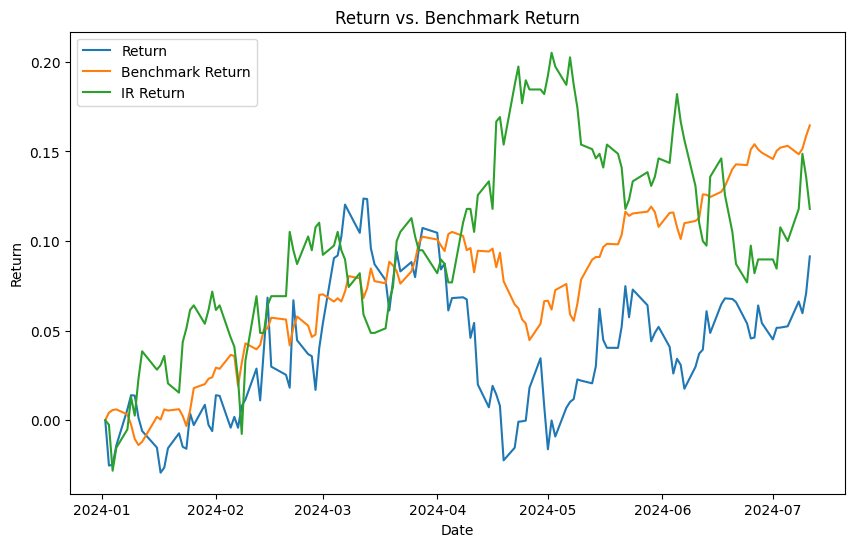

In [92]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [93]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

np.float64(-1.9619859567035867)

In [94]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [95]:
t.sort_values("return",ascending=False).head(10)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,GICS Sector,return,hpr
103,FSLR,251.75,77.077543,0.012802,196.34,2024-05-20,2024-05-22,19404.271535,Information Technology,0.282215,2
5,SMCI,343.31,31.847641,0.164700,285.45,2024-01-02,2024-01-11,10933.613593,Information Technology,0.202697,9
28,PSX,158.96,61.404289,0.119709,133.21,2024-01-09,2024-03-27,9760.825823,Energy,0.193304,78
30,BLDR,189.33,57.091210,0.152020,163.88,2024-01-08,2024-04-11,10809.078712,Industrials,0.155297,94
40,VST,76.86,109.433576,0.046237,66.75,2024-03-20,2024-05-01,8411.064622,Utilities,0.151461,42
20,BALL,62.89,149.412714,0.231242,54.63,2024-01-17,2024-02-23,9396.565561,Materials,0.151199,37
139,SMCI,887.41,24.369526,-0.054768,774.74,2024-06-12,2024-06-17,21625.760694,Information Technology,0.145429,5
92,SMCI,903.94,16.741603,0.043653,798.50,2024-05-10,2024-05-20,15133.404859,Information Technology,0.132048,10
39,SMCI,738.30,17.598105,0.033567,663.35,2024-02-05,2024-05-01,12992.680801,Information Technology,0.112987,86
42,FMC,57.77,179.392241,0.045249,52.38,2024-02-23,2024-05-01,10363.489738,Materials,0.102902,68


In [96]:
t.groupby(["GICS Sector"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return")

,GICS Sector,return,hpr
0,Communication Services,-0.010365,12.666667
2,Consumer Staples,-0.008488,10.555556
9,Real Estate,-0.008043,10.555556
1,Consumer Discretionary,-0.004462,11.875000
6,Industrials,-0.004190,10.000000
5,Health Care,-0.003686,10.555556
3,Energy,-0.003429,11.875000
4,Financials,0.005725,10.555556
8,Materials,0.006033,12.666667
10,Utilities,0.007199,10.611111


In [97]:
holdings = pd.DataFrame(sum([[x["stocks"][i] for x in states[-1]["positions"]] for i in range(number_of_stocks)],[]))
db.cloud_connect()
db.drop("trades")
db.drop("holdings")
db.drop("visualization")
db.store("visualization",visualization)
db.store("trades",t)
db.store("holdings",holdings)
db.disconnect() 